# Bayesian Linear Regression
Based on the Seoul Bike Sharing Demand dataset located at ../data/SeoulBikeData.csv
Load the data and split into train and test sets, 80% for training and 20% for testing.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pymc as pm
import arviz as az

from mpl_toolkits.axes_grid1 import make_axes_locatable
from io import BytesIO
import seaborn as sns


Data Preprocessing, make sure to convert the categorical variables into numeric variables.

In [55]:
file_path = '../data/SeoulBikeData.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')
numeric_season = {'Spring' : 1, 'Summer' : 2, 'Autumn' : 3, 'Winter' : 4}
numeric_holiday = {'No Holiday' : 0, 'Holiday' : 1}
numeric_functioning_day = {'No' : 0, 'Yes' : 1}
df['Seasons'] = df['Seasons'].map(numeric_season)
df['Holiday'] = df['Holiday'].map(numeric_holiday)
df['Functioning Day'] = df['Functioning Day'].map(numeric_functioning_day)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
#df['DayOfWeek'] = df['Date'].dt.dayofweek

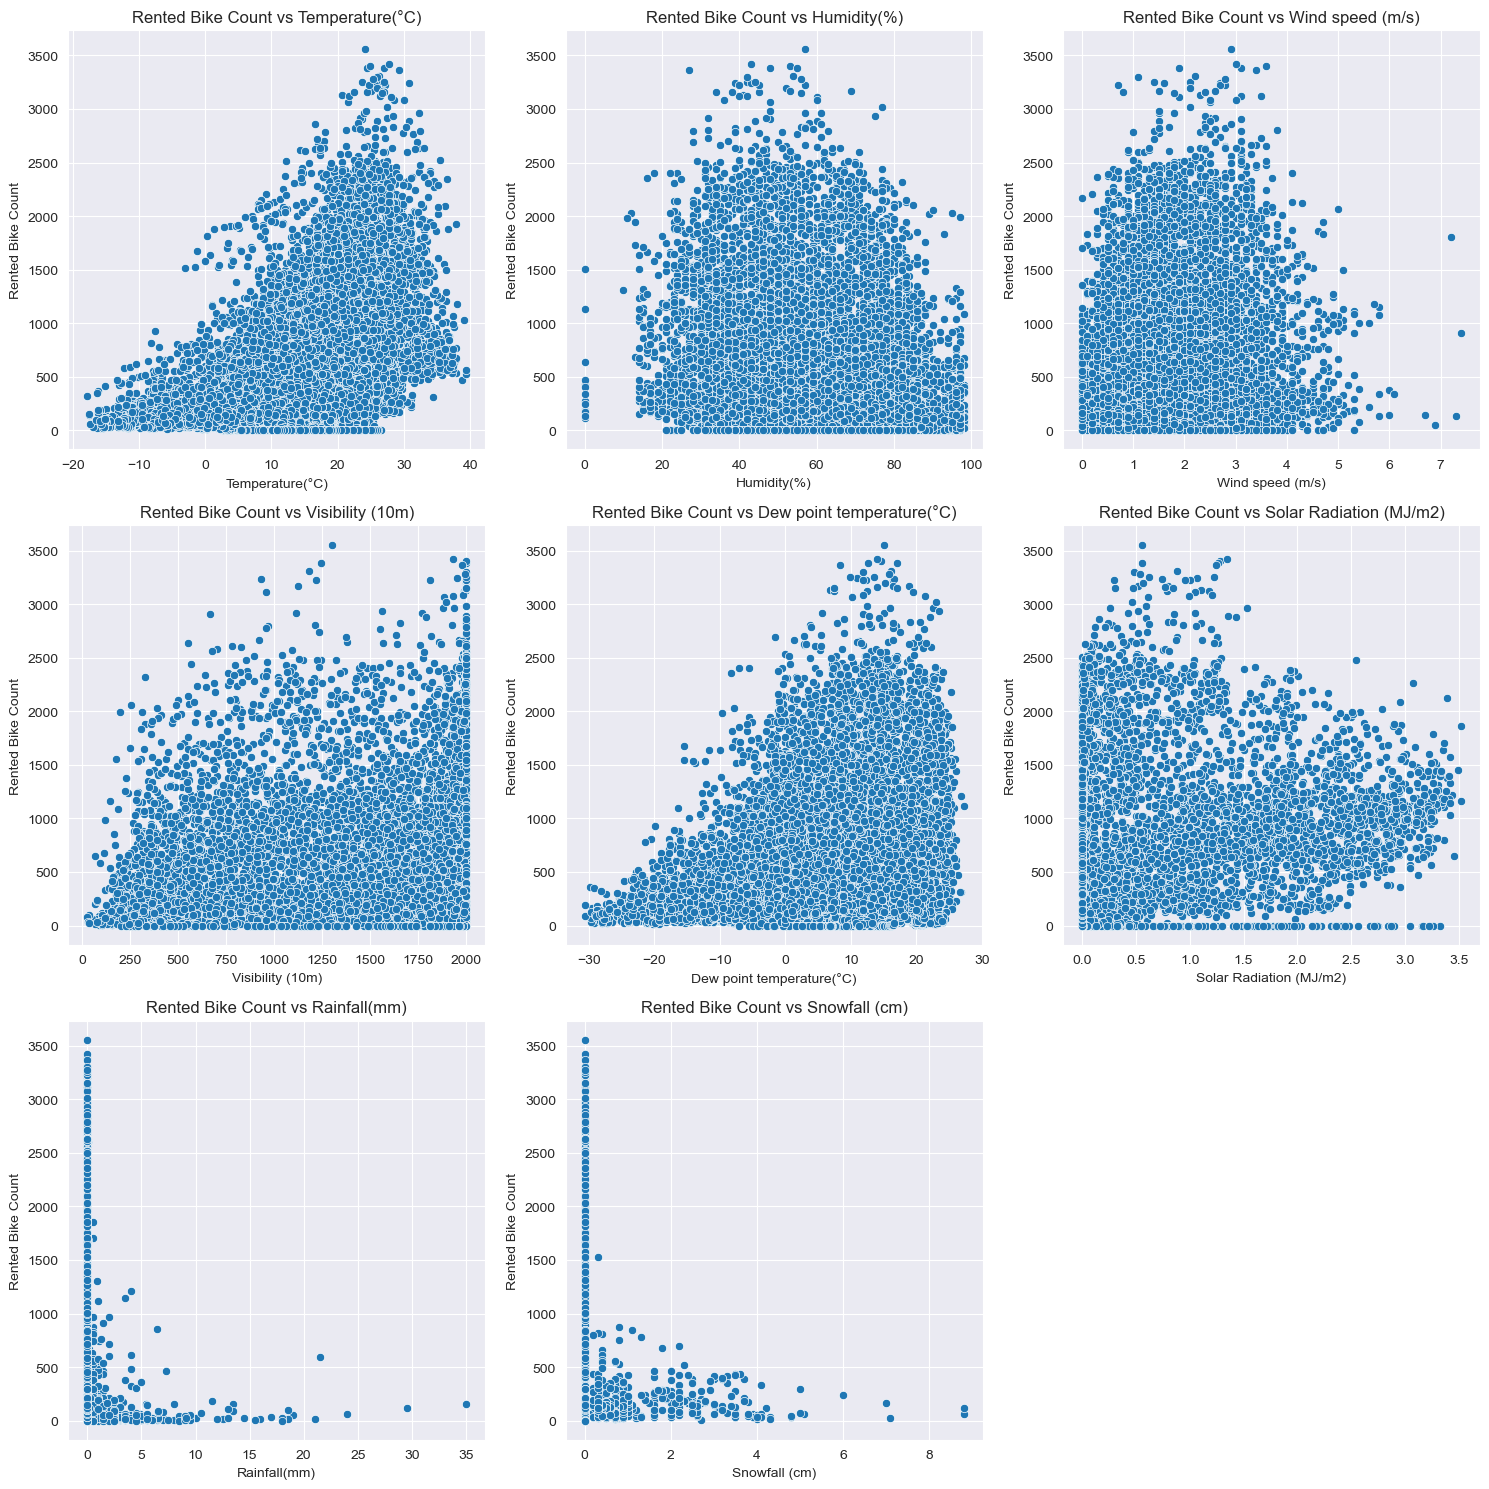

In [43]:
# Selecting a few numerical variables for scatter plots
numerical_vars = ['Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

# Setting up the plot
plt.figure(figsize=(15, 15))

for i, var in enumerate(numerical_vars, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(data=df, x=var, y='Rented Bike Count')
    plt.title(f'Rented Bike Count vs {var}')

plt.tight_layout()
plt.show()

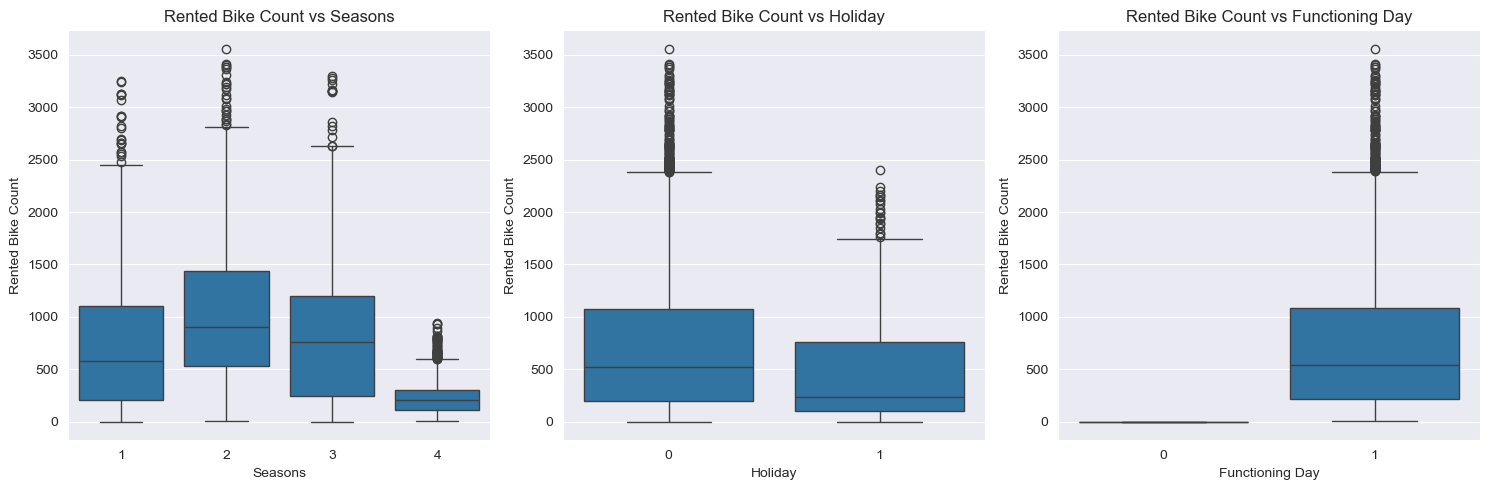

In [38]:
# Selecting categorical variables
categorical_vars = ['Seasons', 'Holiday', 'Functioning Day']

# Setting up the plot
plt.figure(figsize=(15, 5))

for i, var in enumerate(categorical_vars, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=df, x=var, y='Rented Bike Count')
    plt.title(f'Rented Bike Count vs {var}')

plt.tight_layout()
plt.show()


Process data and create new features
Rainfall and Snowfall are highly skewed, so we will create new features to indicate if it rained or snowed on a given day. Also create a new feature to indicate if the day is a weekend or not.

In [56]:
df['IsWeekend'] = df['Date'].dt.dayofweek >= 5
df['IsWeekend'] = df['IsWeekend'].astype(int)
df['Rain'] = (df['Rainfall(mm)'] > 0).astype(int)
df['Snow'] = (df['Snowfall (cm)'] > 0).astype(int)

df.drop(['Date', 'Rainfall(mm)', 'Snowfall (cm)'], axis=1, inplace=True)

print(df.head())

X = df.drop(['Rented Bike Count'], axis=1)
y = df['Rented Bike Count']

# Print the shapes of the features and target
print("DataFrame shape:", df.shape)
print("Features shape:", X.shape)
print("Target shape:", y.shape)

   Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
0                254     0             -5.2           37               2.2   
1                204     1             -5.5           38               0.8   
2                173     2             -6.0           39               1.0   
3                107     3             -6.2           40               0.9   
4                 78     4             -6.0           36               2.3   

   Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
0              2000                      -17.6                      0.0   
1              2000                      -17.6                      0.0   
2              2000                      -17.7                      0.0   
3              2000                      -17.6                      0.0   
4              2000                      -18.6                      0.0   

   Seasons  Holiday  Functioning Day  IsWeekend  Rain  Snow  
0        4        

In [57]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale the data
scaler = StandardScaler()
columns_to_scale = X.columns.difference(['Seasons', 'Holiday', 'Functioning Day', 'IsWeekend', 'Rain', 'Snow'])
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

print(X_train.isnull().any())
print('-------------------')
print(X_test.isnull().any())


Hour                         False
Temperature(°C)              False
Humidity(%)                  False
Wind speed (m/s)             False
Visibility (10m)             False
Dew point temperature(°C)    False
Solar Radiation (MJ/m2)      False
Seasons                      False
Holiday                      False
Functioning Day              False
IsWeekend                    False
Rain                         False
Snow                         False
dtype: bool
-------------------
Hour                         False
Temperature(°C)              False
Humidity(%)                  False
Wind speed (m/s)             False
Visibility (10m)             False
Dew point temperature(°C)    False
Solar Radiation (MJ/m2)      False
Seasons                      False
Holiday                      False
Functioning Day              False
IsWeekend                    False
Rain                         False
Snow                         False
dtype: bool


In [58]:
X_train_np = X_train.to_numpy(dtype=np.float32)
X_test_np = X_test.to_numpy(dtype=np.float32)
y_train_np = y_train.to_numpy(dtype=np.float32)
y_test_np = y_test.to_numpy(dtype=np.float32)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print(X_train.head())
print(X_train.describe())

Training set size: (7008, 13)
Test set size: (1752, 13)
          Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
8415  0.505421         0.022370     0.137012          2.092940   
5049 -0.363566         0.838222     1.359982         -0.029683   
8395  1.084745        -0.145847    -0.596770         -0.319131   
1535  1.664070        -1.306543     0.528362          0.259766   
5518  1.519239         1.199888     0.724038         -0.222648   

      Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
8415         -1.176113                   0.130553                 0.519701   
5049         -1.472667                   1.255469                 0.210677   
8395         -0.930350                  -0.316331                -0.659168   
1535         -0.004643                  -0.894198                -0.659168   
5518         -0.707525                   1.371043                -0.659168   

      Seasons  Holiday  Functioning Day  IsWeekend  Rain  Snow  
8415        3

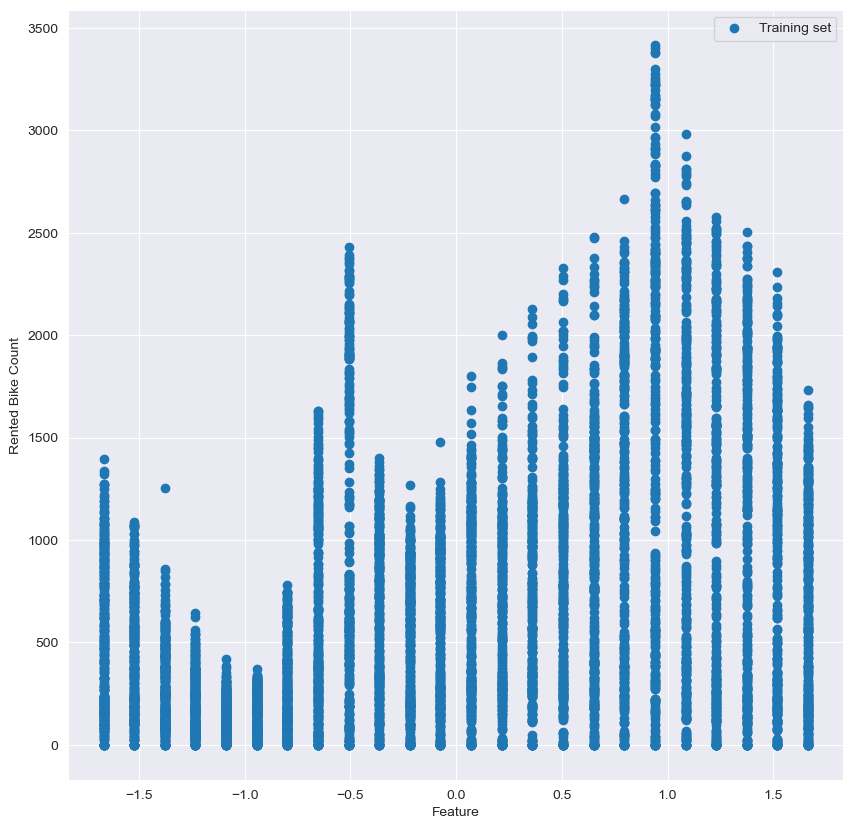

In [59]:
# plot the data
plt.figure(figsize=(10, 10))
plt.scatter(X_train_np[:, 0], y_train_np, label='Training set')
plt.xlabel('Feature')
plt.ylabel('Rented Bike Count')
plt.legend()
plt.show()

#### Bayesian Linear Regression
Use PyMC to perform Bayesian Linear Regression on your new dataset. 

In [60]:
with pm.Model() as model:

    w0 = pm.Normal('w0', mu=0, sigma=20)

    ws = pm.Normal('ws', mu=0, sigma=20, shape=X_train.shape[1])

    y_est = w0 + pm.math.dot(X_train, ws)

    sigma = pm.Uniform('sigma', lower=0, upper=20)
    likelihood = pm.Normal('y', mu=y_est, sigma=sigma, observed=y_train)

    trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w0, ws, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


Sampling: [y]


<Figure size 1000x600 with 0 Axes>

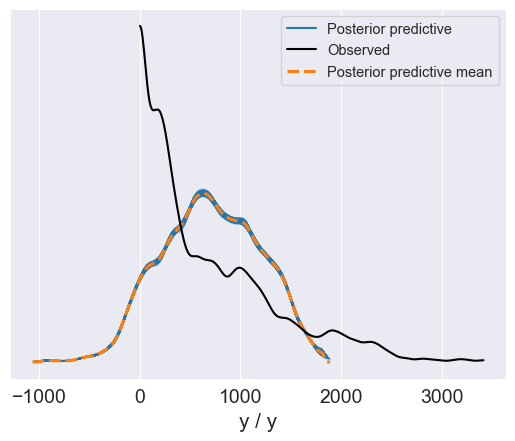

In [61]:
with model:
    y_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

plt.figure(figsize=(10, 6))
az.plot_ppc(y_pred)
plt.show()

In [62]:
with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    betas = pm.Normal('beta', mu=0, sigma=10, shape=X_train_np.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Expected value of outcome
    mu = alpha + pm.math.dot(X_train_np, betas)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_train_np)

    # Inference
    trace = pm.sample(1000, tune=500, cores=2)  # Adjust the number of cores based on your machine

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Posterior Predictive Check, plot the posterior predictive distribution of the model

<Figure size 1000x1000 with 0 Axes>

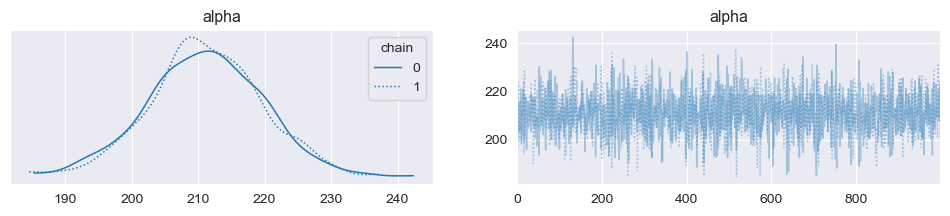

<Figure size 1000x1000 with 0 Axes>

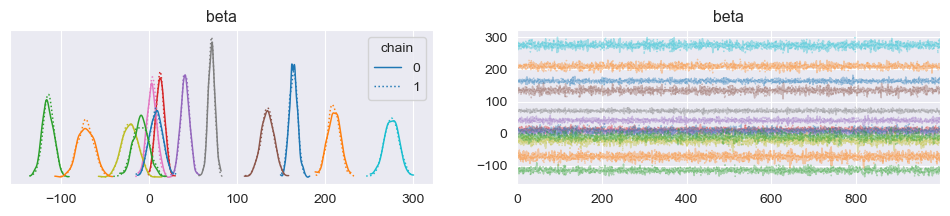

<Figure size 1000x1000 with 0 Axes>

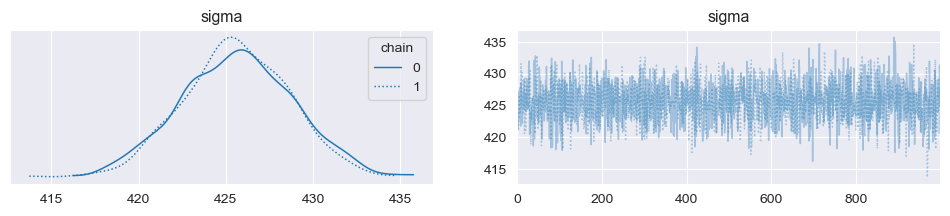

In [63]:
plt.figure(figsize=(10, 10))
az.plot_trace(trace, combined=False, var_names=['alpha'], legend=True)
plt.show()
plt.figure(figsize=(10, 10))
az.plot_trace(trace, combined=False, var_names=['beta'], legend=True)
plt.show()
plt.figure(figsize=(10, 10))
az.plot_trace(trace, combined=False, var_names=['sigma'], legend=True)
plt.show()

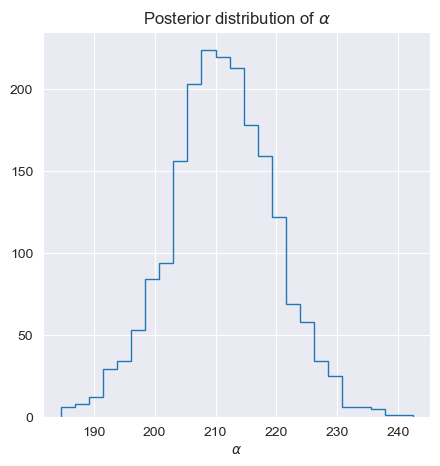

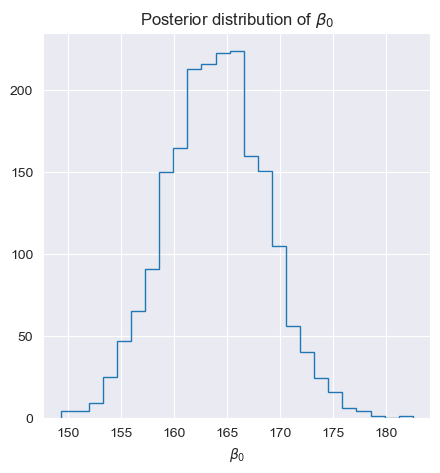

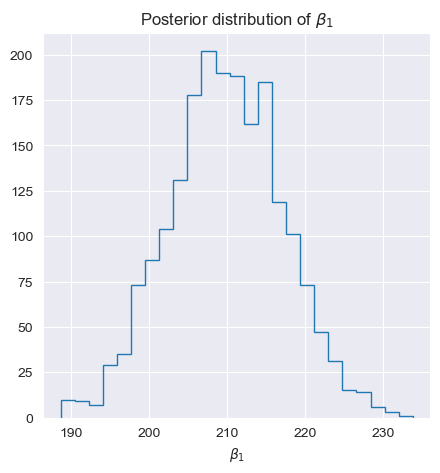

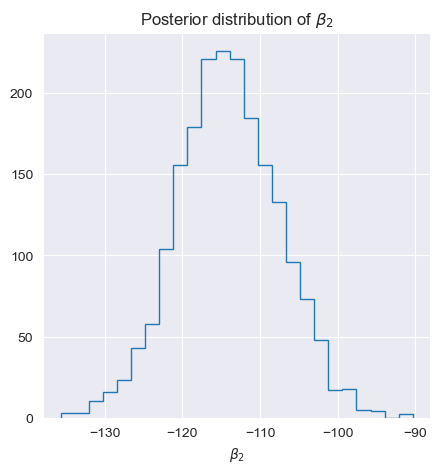

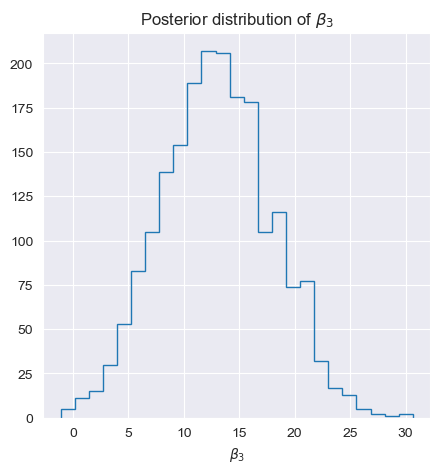

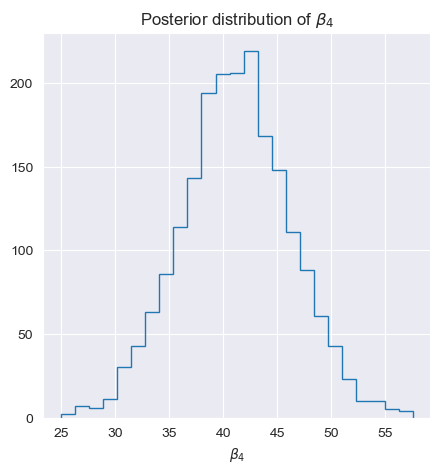

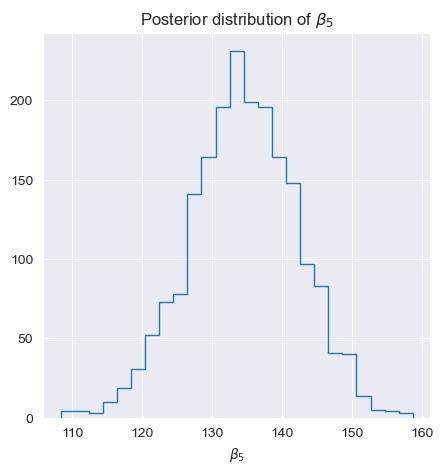

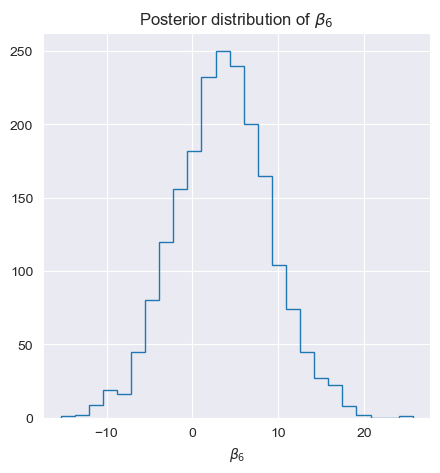

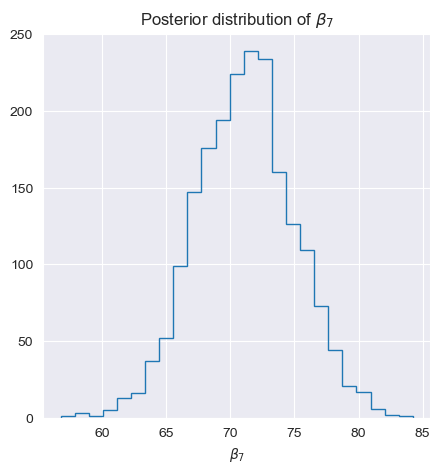

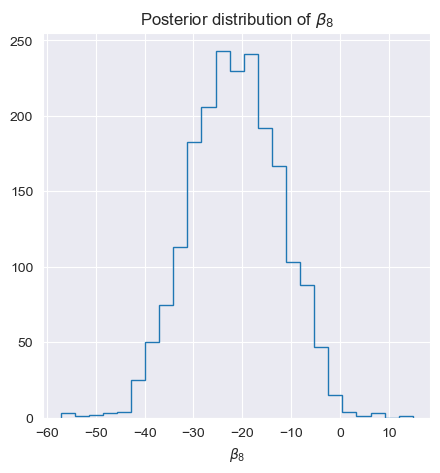

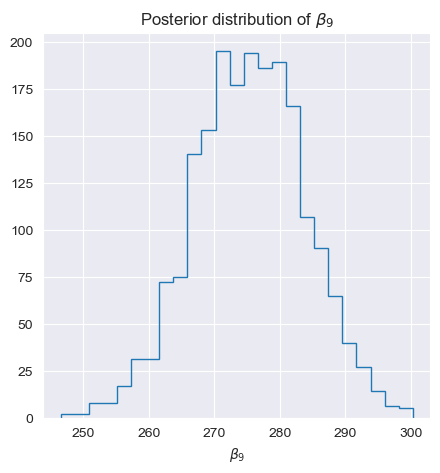

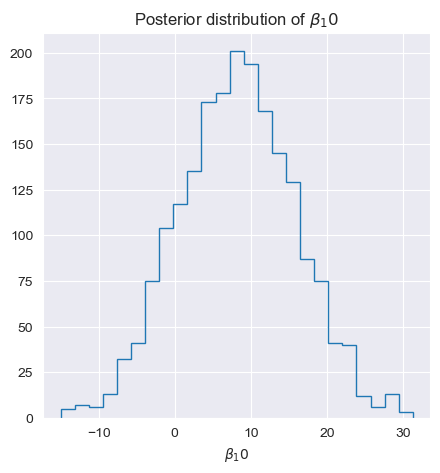

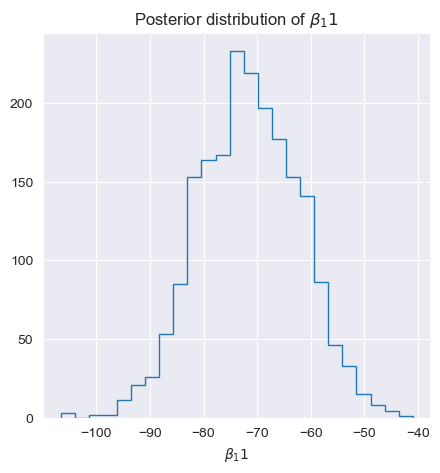

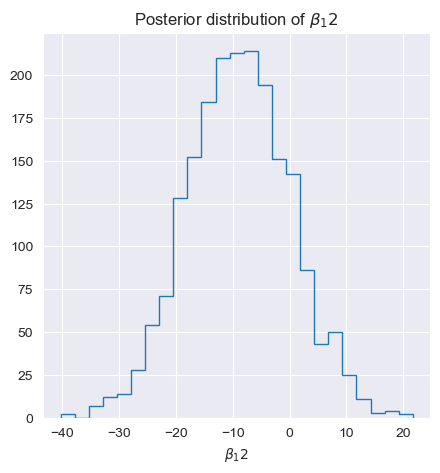

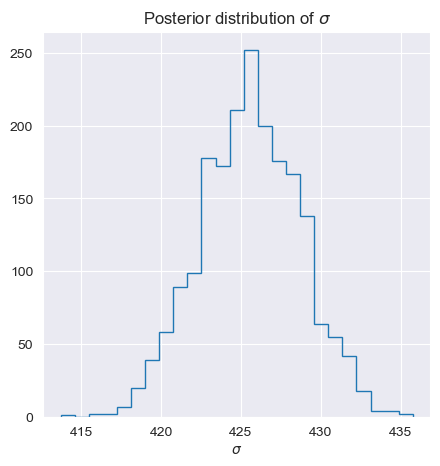

In [64]:
# plot the posterior distributions
plt.figure(figsize=(5, 5))
plt.hist(trace.posterior['alpha'].values.flatten(), bins=25, histtype='step')
plt.xlabel('$\\alpha$')
plt.title('Posterior distribution of $\\alpha$')
plt.show()

# for betas in the model 
for i in range(trace.posterior['beta'].shape[-1]):
    plt.figure(figsize=(5, 5))
    plt.hist(trace.posterior['beta'].sel(beta_dim_0=i).values.flatten(), bins=25, histtype='step')
    plt.xlabel(f'$\\beta_{i}$')
    plt.title(f'Posterior distribution of $\\beta_{i}$')
    plt.show()


plt.figure(figsize=(5, 5))
plt.hist(trace.posterior['sigma'].values.flatten(), bins=25, histtype='step')
plt.xlabel('$\\sigma$')
plt.title('Posterior distribution of $\\sigma$')
plt.show()


Summery posterior mean value for each model parameter generated by arviz.summary

In [65]:
# print the summary of the posterior distribution
summary = az.summary(trace)
print(summary)

             mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha     211.088  8.588  194.673  227.373      0.170    0.120    2554.0   
beta[0]   163.982  4.647  155.219  172.756      0.088    0.062    2762.0   
beta[1]   209.847  7.294  197.054  224.120      0.158    0.111    2141.0   
beta[2]  -114.088  6.544 -125.735 -101.644      0.140    0.099    2181.0   
beta[3]    12.983  4.957    3.939   21.984      0.084    0.067    3483.0   
beta[4]    41.195  5.052   32.448   51.546      0.089    0.063    3188.0   
beta[5]   134.507  7.630  121.377  150.075      0.158    0.112    2338.0   
beta[6]     3.595  5.469   -6.188   14.313      0.111    0.108    2450.0   
beta[7]    71.162  3.815   63.757   77.949      0.079    0.056    2318.0   
beta[8]   -21.404  9.154  -37.461   -4.033      0.153    0.126    3531.0   
beta[9]   275.366  8.465  260.405  292.158      0.169    0.120    2501.0   
beta[10]    8.262  7.585   -6.427   21.671      0.119    0.128    4011.0   
beta[11]  -7

Sampling: [Y_obs]


<Figure size 1000x600 with 0 Axes>

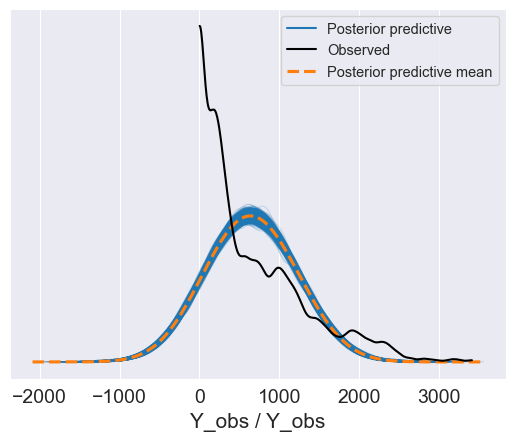

In [66]:
with model:
    y_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

plt.figure(figsize=(10, 6))
az.plot_ppc(y_pred)
plt.show()

#### Bayesian Linear Regression with Log Transformation
The previous model is not performing well, try to improve the model by log transforming the target variable.

In [67]:
y_train_log = np.log(y_train + 1)  # Add 1 to avoid log(0)

num_samples = 1000

with pm.Model() as model:
    n_features = X_train.shape[1]  # Number of features in X_train

    # Adjusted priors for the regression coefficients based on standardized features
    beta = pm.Normal('beta', mu=0, sigma=1, shape=n_features)
    alpha = pm.Normal('alpha', mu=0, sigma=0.5)  # Assuming the mean of y_train_log is around 0 after log transformation
    sigma = pm.Exponential('sigma', 1)

    # Expected value of outcome (in log scale)
    mu_log = alpha + pm.math.dot(X_train, beta)

    # Model the outcome variable in log scale
    Y_obs_log = pm.Normal('Y_obs_log', mu=mu_log, sigma=sigma, observed=y_train_log)

    # Sample from the posterior
    trace = pm.sample(num_samples, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


<Figure size 1000x1000 with 0 Axes>

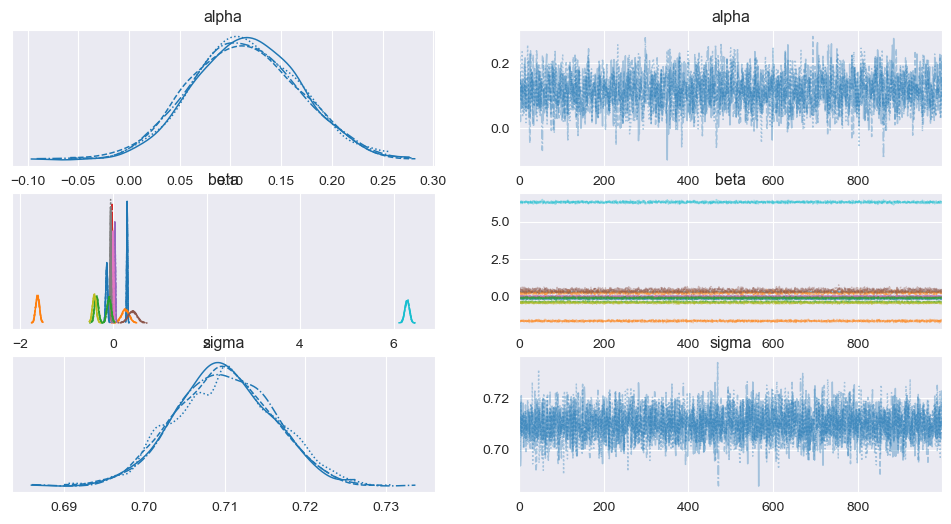

In [68]:
plt.figure(figsize=(10, 10))
az.plot_trace(trace, combined=False, var_names=['alpha', 'beta', 'sigma'])
plt.show()

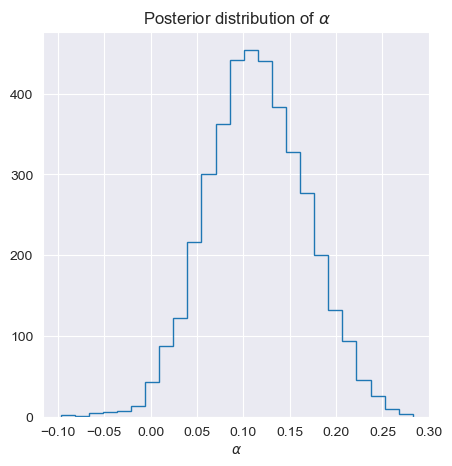

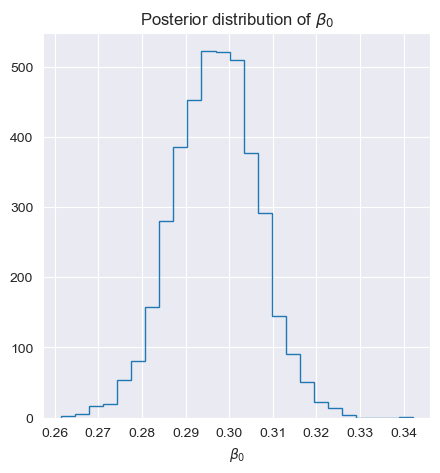

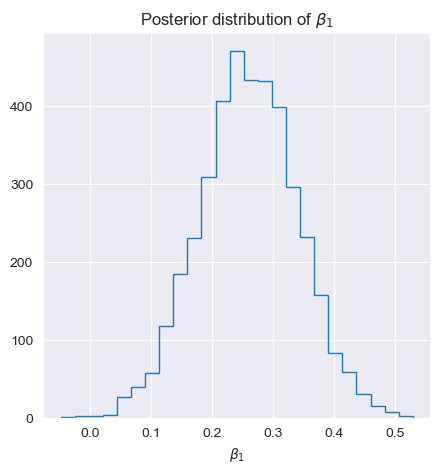

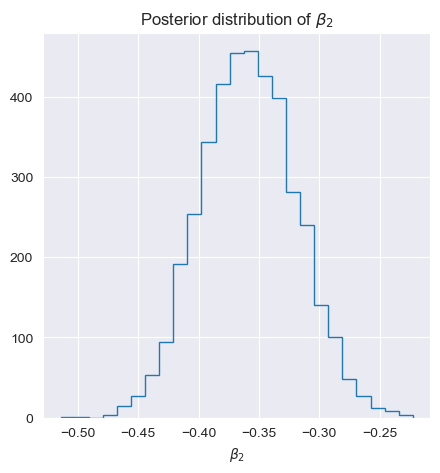

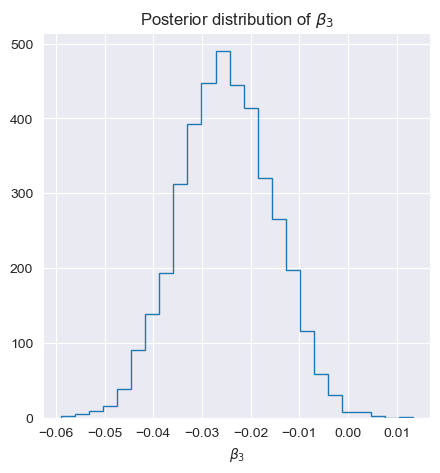

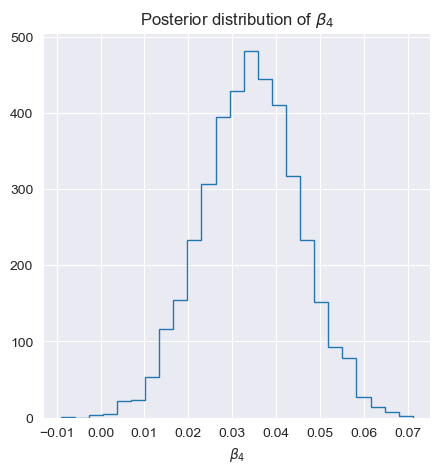

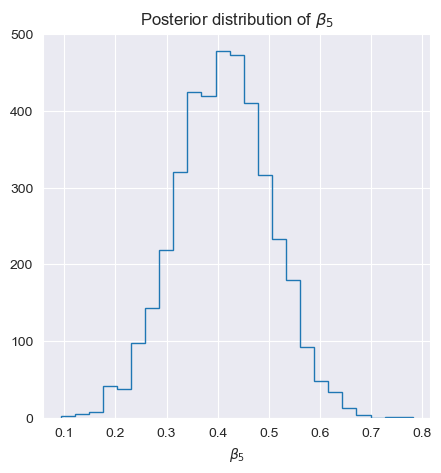

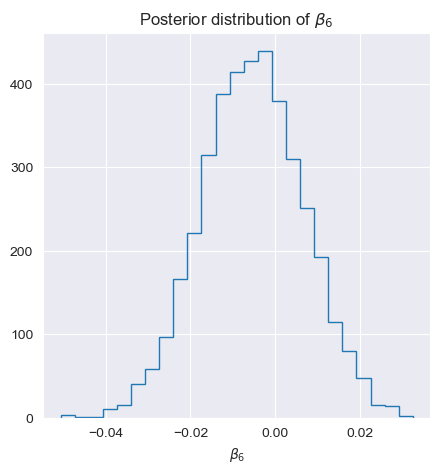

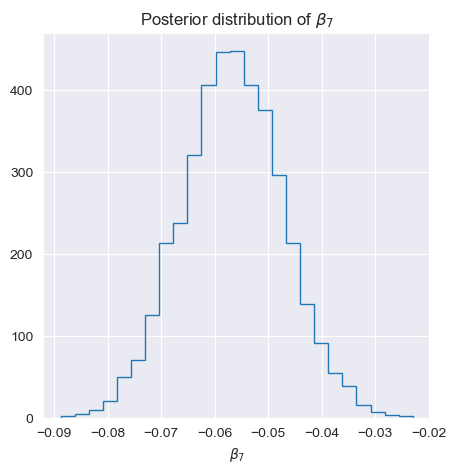

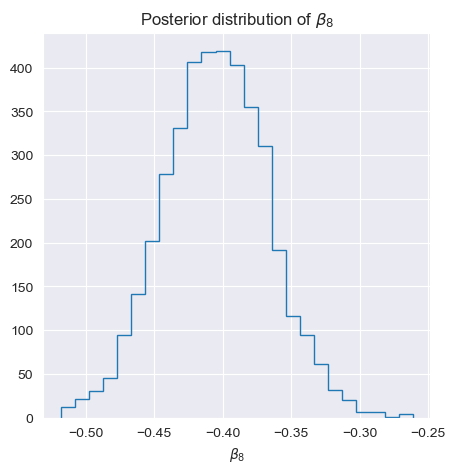

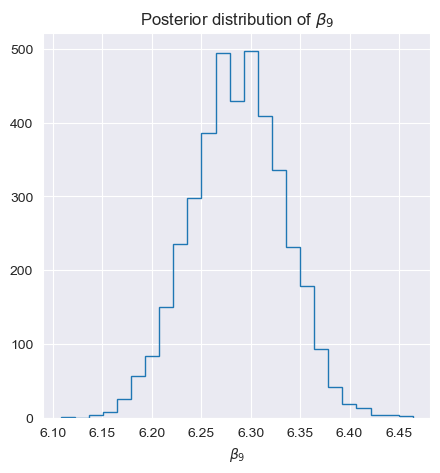

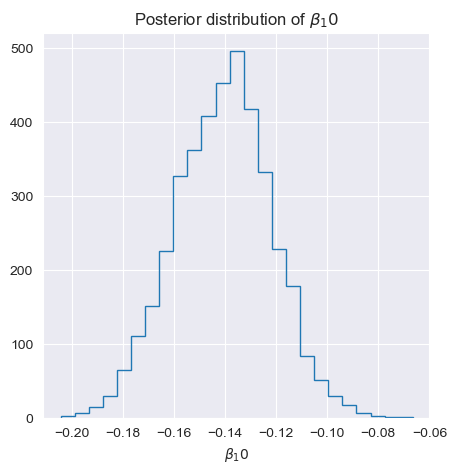

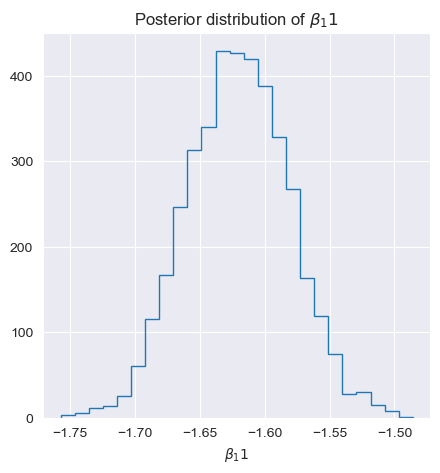

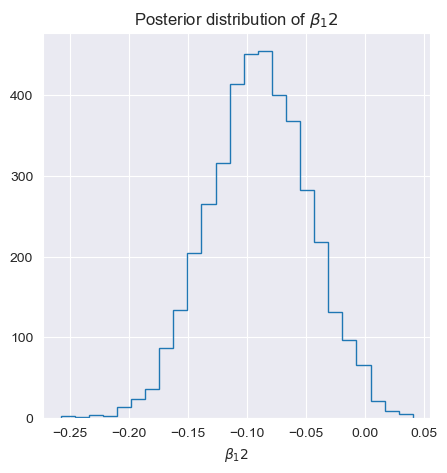

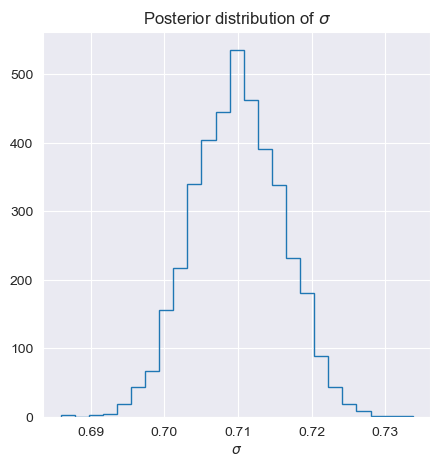

In [69]:
# plot the posterior distributions
plt.figure(figsize=(5, 5))
plt.hist(trace.posterior['alpha'].values.flatten(), bins=25, histtype='step')
plt.xlabel('$\\alpha$')
plt.title('Posterior distribution of $\\alpha$')
plt.show()

# for 13 betas in the model 
for i in range(trace.posterior['beta'].shape[-1]):
    plt.figure(figsize=(5, 5))
    plt.hist(trace.posterior['beta'].sel(beta_dim_0=i).values.flatten(), bins=25, histtype='step')
    plt.xlabel(f'$\\beta_{i}$')
    plt.title(f'Posterior distribution of $\\beta_{i}$')
    plt.show()


plt.figure(figsize=(5, 5))
plt.hist(trace.posterior['sigma'].values.flatten(), bins=25, histtype='step')
plt.xlabel('$\\sigma$')
plt.title('Posterior distribution of $\\sigma$')
plt.show()

In [70]:
# print the summary of the posterior distribution
summary = az.summary(trace)
print(summary)

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]   0.297  0.010   0.279    0.315      0.000    0.000    4433.0   
beta[1]   0.260  0.080   0.105    0.403      0.002    0.002    1255.0   
beta[2]  -0.358  0.039  -0.429   -0.284      0.001    0.001    1369.0   
beta[3]  -0.025  0.010  -0.043   -0.008      0.000    0.000    4155.0   
beta[4]   0.034  0.011   0.013    0.054      0.000    0.000    3224.0   
beta[5]   0.412  0.092   0.243    0.584      0.003    0.002    1267.0   
beta[6]  -0.005  0.012  -0.027    0.018      0.000    0.000    3040.0   
beta[7]  -0.057  0.009  -0.074   -0.039      0.000    0.000    2689.0   
beta[8]  -0.405  0.038  -0.476   -0.333      0.001    0.000    4556.0   
beta[9]   6.287  0.047   6.201    6.375      0.001    0.001    2405.0   
beta[10] -0.141  0.019  -0.176   -0.105      0.000    0.000    3854.0   
beta[11] -1.620  0.039  -1.694   -1.549      0.001    0.000    3221.0   
beta[12] -0.089  0.042  -0.167   -0.012      0.001 

Sampling: [Y_obs_log]


<Figure size 1000x600 with 0 Axes>

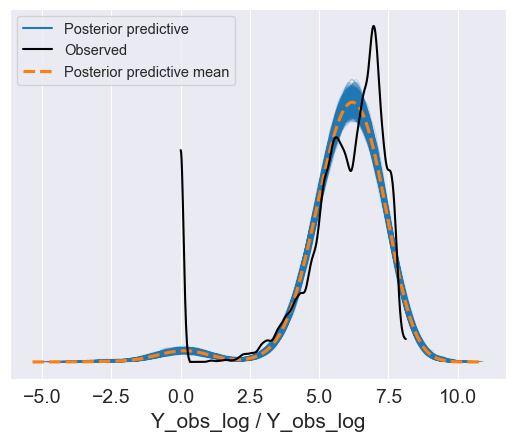

In [71]:
with model:
    y_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

plt.figure(figsize=(10, 6))
az.plot_ppc(y_pred)
plt.show()

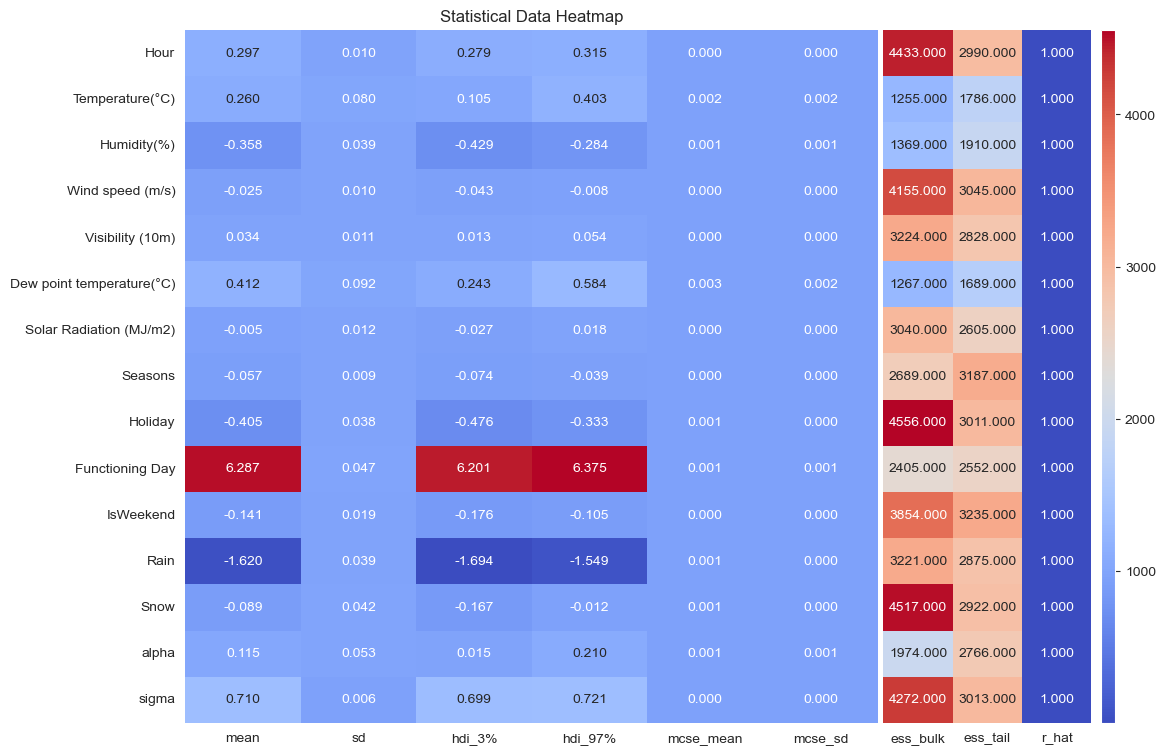

In [72]:
feature_names = X_train.columns.tolist()
data = {
    'mean': [0.297, 0.260, -0.358, -0.025, 0.034, 0.412, -0.005, -0.057, -0.405, 6.287, -0.141, -1.620, -0.089, 0.115, 0.710],
    'sd': [0.010, 0.080, 0.039, 0.010, 0.011, 0.092, 0.012, 0.009, 0.038, 0.047, 0.019, 0.039, 0.042, 0.053, 0.006],
    'hdi_3%': [0.279, 0.105, -0.429, -0.043, 0.013, 0.243, -0.027, -0.074, -0.476, 6.201, -0.176, -1.694, -0.167, 0.015, 0.699],
    'hdi_97%': [0.315, 0.403, -0.284, -0.008, 0.054, 0.584, 0.018, -0.039, -0.333, 6.375, -0.105, -1.549, -0.012, 0.210, 0.721],
    'mcse_mean': [0.000, 0.002, 0.001, 0.000, 0.000, 0.003, 0.000, 0.000, 0.001, 0.001, 0.000, 0.001, 0.001, 0.001, 0.000],
    'mcse_sd': [0.000, 0.002, 0.001, 0.000, 0.000, 0.002, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.001, 0.000],
    'ess_bulk': [4433.0, 1255.0, 1369.0, 4155.0, 3224.0, 1267.0, 3040.0, 2689.0, 4556.0, 2405.0, 3854.0, 3221.0, 4517.0, 1974.0, 4272.0],
    'ess_tail': [2990.0, 1786.0, 1910.0, 3045.0, 2828.0, 1689.0, 2605.0, 3187.0, 3011.0, 2552.0, 3235.0, 2875.0, 2922.0, 2766.0, 3013.0],
    'r_hat': [1.0] * 15
}

df = pd.DataFrame(data)
df.index = feature_names + ['alpha', 'sigma']
fig, ax = plt.subplots(figsize=(12, 9))

divider = make_axes_locatable(ax)

left_size = 6 / (6 + 3 + 1)  
right_size = 3 / (6 + 3 + 1)

cax = divider.append_axes("right", size=f"{right_size * 100}%", pad=0.05)
sns.heatmap(df.iloc[:, :6], ax=ax, cbar=False, annot=True, fmt=".3f", cmap="coolwarm")
heatmap = sns.heatmap(df.iloc[:, 6:], ax=cax, cbar=False, annot=True, fmt=".3f", cmap="coolwarm")

cax.yaxis.set_visible(False)
cbar_ax = divider.append_axes("right", size="2%", pad=0.1)
plt.colorbar(heatmap.collections[0], cax=cbar_ax, orientation='vertical')
ax.set_title('Statistical Data Heatmap')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

img_buf = BytesIO()
plt.savefig(img_buf, format='png', bbox_inches='tight')
img_buf.seek(0)
plt.show()
img_buf